### 1. Load the dataset

**[1.1] Automatic reload modules**

In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**[1.2] Import packages**

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

**[1.3] Load the datasets**

In [15]:
X_train = pd.read_csv('../data/processed/X_train2.csv')
X_val   = pd.read_csv('../data/processed/X_val2.csv')
X_test  = pd.read_csv('../data/processed/X_test2.csv')
y_train = pd.read_csv('../data/processed/y_train2.csv')
y_val   = pd.read_csv('../data/processed/y_val2.csv')
y_test = pd.read_csv('../data/interim/y_test.csv')

### 2. Feature Engineering

* Based on feature importance done in the previous experiment, the least significant features will be excluded in this experiment.

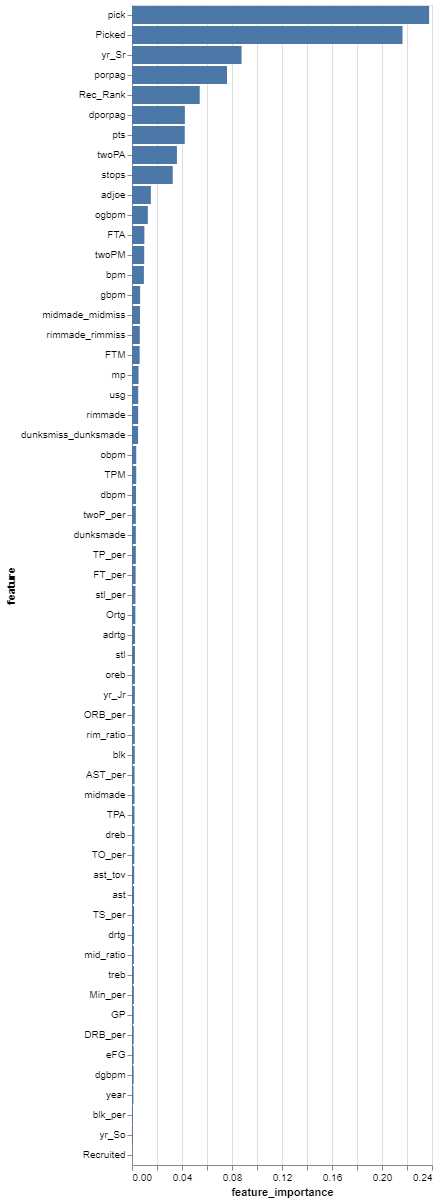

In [16]:
#list the features
X_train.columns

Index(['yr_Jr', 'yr_So', 'yr_Sr', 'GP', 'Min_per', 'Ortg', 'usg', 'eFG',
       'TS_per', 'ORB_per', 'DRB_per', 'AST_per', 'TO_per', 'FTM', 'FTA',
       'FT_per', 'twoPM', 'twoPA', 'twoP_per', 'TPM', 'TPA', 'TP_per',
       'blk_per', 'stl_per', 'porpag', 'adjoe', 'year', 'Rec_Rank', 'ast_tov',
       'rimmade', 'rimmade_rimmiss', 'midmade', 'midmade_midmiss', 'rim_ratio',
       'mid_ratio', 'dunksmade', 'dunksmiss_dunksmade', 'pick', 'drtg',
       'adrtg', 'dporpag', 'stops', 'bpm', 'obpm', 'dbpm', 'gbpm', 'mp',
       'ogbpm', 'dgbpm', 'oreb', 'dreb', 'treb', 'ast', 'stl', 'blk', 'pts',
       'Picked', 'Recruited'],
      dtype='object')

In [17]:
to_keep = ['pick', 'Picked', 'yr_Jr', 'yr_So', 'yr_Sr', 'porpag', 'dporpag', 
            'Rec_Rank', 'pts', 'stops', 'twoPA', 'adjoe', 'ogbpm', 'FTA',
           'twoPM', 'bpm',  'gbpm', 'midmade_midmiss', 'rimmade_rimmiss',
           'FTM', 'mp', 'usg', 'rimmade', 'dunksmiss_dunksmade', 'obpm', 
           'TPM', 'dbpm', 'twoP_per', 'dunksmade', 'TP_per']

In [18]:
X_train = X_train[to_keep]
X_val = X_val[to_keep]
X_test = X_test[to_keep]

X_train.columns

Index(['pick', 'Picked', 'yr_Jr', 'yr_So', 'yr_Sr', 'porpag', 'dporpag',
       'Rec_Rank', 'pts', 'stops', 'twoPA', 'adjoe', 'ogbpm', 'FTA', 'twoPM',
       'bpm', 'gbpm', 'midmade_midmiss', 'rimmade_rimmiss', 'FTM', 'mp', 'usg',
       'rimmade', 'dunksmiss_dunksmade', 'obpm', 'TPM', 'dbpm', 'twoP_per',
       'dunksmade', 'TP_per'],
      dtype='object')

In [19]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(33020, 30)
(8256, 30)
(4970, 30)


In [20]:
y_train = y_train.values.ravel()
y_val = y_val.values.ravel()

### 3. Train RandomForest - Hyperparameter Tuning with RandomSearchCV

**[3.1] Instantiate and fit the model**

In [21]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=8)

**[3.2] Parameters dictionary**

In [22]:
from scipy.stats import randint

param_ran = {
    'n_estimators': randint(5, 100),
    'max_depth': randint(5, 30),
    'min_samples_leaf': randint(10, 100),
    'max_features': randint(2, 30)
}

**[3.3] Instantiate and fit the hyperparameters wit Stratified KFold**

In [23]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=8)
ransearch = RandomizedSearchCV(rf, param_ran, cv=skf, random_state=8)

In [24]:
ransearch.fit(X_train, y_train)

C:\Users\ting_\AppData\Local\pypoetry\Cache\virtualenvs\at1-kaggle-group12-lV0VH6Hd-py3.11\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=8, shuffle=True),
                   estimator=RandomForestClassifier(random_state=8),
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000020CB766B550>,
                                        'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000020CBA9E5C10>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000020CBA9E6910>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000020CB8C1E910>},
                   random_state=8)

**[3.4] Display the best set of parameters**

In [25]:
ransearch.best_params_

{'max_depth': 8,
 'max_features': 22,
 'min_samples_leaf': 15,
 'n_estimators': 95}

**[3.5] Evaluation metrics for hyperparameters**

In [26]:
ransearch.best_score_

np.float64(0.9958812840702604)

In [27]:
print("RanCV_Train:", f'{ransearch.score(X_train, y_train):.4f}')
print("RanCV_val:", f'{ransearch.score(X_val, y_val):.4f}')

RanCV_Train: 0.9972
RanCV_val: 0.9969


**[3.6] Make prediction on training data**

In [28]:
y_train_pred = ransearch.best_estimator_.predict_proba(X_train)[:, 1]
y_val_pred = ransearch.best_estimator_.predict_proba(X_val)[:, 1]

**[3.7] Performance metric - AUROC**

In [29]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

In [30]:
print("Train - AUROC:\n", f'{roc_auc_score(y_train, y_train_pred):.4f}')
print("Val - AUROC:\n", f'{roc_auc_score(y_val, y_val_pred):.4f}')

Train - AUROC:
 0.9993
Val - AUROC:
 0.9988


**Plot the AUROC curve**

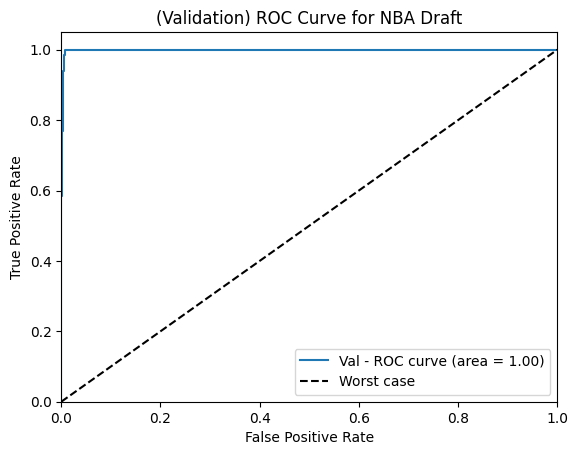

In [31]:
fpr, tpr, thresholds = roc_curve(y_val, y_val_pred) 
roc_auc = auc(fpr, tpr)
plt.figure()  
plt.plot(fpr, tpr, label='Val - ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='Worst case')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(Validation) ROC Curve for NBA Draft')
plt.legend()
plt.show()

**[3.8] Predict on test data**

In [32]:
y_test_pred = ransearch.best_estimator_.predict_proba(X_test)[:, 1]

#Dataframe for pred result
y_pred = y_test
y_pred.loc[:, 'drafted'] = y_test_pred

print(y_pred.describe().round(5))

y_pred = pd.DataFrame(y_pred)

#Save the result to CSV file
y_pred.to_csv('../data/external/at1_pred_week2.4.csv', index=False)

          drafted
count  4970.00000
mean      0.00419
std       0.04921
min       0.00000
25%       0.00000
50%       0.00000
75%       0.00000
max       0.93937


### 4. Feature Importance

In [33]:
feature = ransearch.best_estimator_.feature_importances_

In [34]:
#Dataframe of feature importance
feat_imp_rf_df = pd.DataFrame(
    {'feature': X_train.columns,
     'feature_importance': feature})

In [35]:
#Sort the dataframe
feat_imp_rf_df = feat_imp_rf_df.sort_values('feature_importance', ascending=False).reset_index(drop=True)
feat_imp_rf_df

,feature,feature_importance
0,Picked,0.277239
1,pick,0.204938
2,yr_Sr,0.118305
3,pts,0.092674
4,Rec_Rank,0.061681
5,porpag,0.044563
6,twoPA,0.042547
7,dporpag,0.037860
8,stops,0.014865
9,adjoe,0.011149


In [36]:
#Visualize the feature importance
import altair as alt

alt.Chart(feat_imp_rf_df).mark_bar().encode(
    x='feature_importance',
    y=alt.Y("feature", sort='-x'),
    tooltip=['feature','feature_importance']
)

alt.Chart(...)